# Fitting stress-strain data

This tutorial will cover how to

* Fit stress-strain data
* Fit stress-strain in hydrogel models at constant hydration

**Currently, `ucompress.py` is only able to fit to stress-strain data associated with the instantaneous response of samples to a load**

In [1]:
import ucompress as uc
import numpy as np
import matplotlib.pyplot as plt

## Preliminaries - Data generation

In this section, we generate some synthetic data for a neo-Hookean poroelastic material.  This will be used to validate the fitting procedure.

In [2]:
# Define the parameter set and mechanical model
pars = uc.parameters.example_parameters.NeoHookean(nondim = False)
mech = uc.mechanics.NeoHookean()

# update the Poisson's ratio
pars.update('nu_m', 0.3)

# Build the model
model = uc.base_models.Poroelastic(mech, None, pars)

We now calculate the stresses assuming an instantaneous response

In [3]:
# Define stretches
lam_z = np.linspace(0.5, 2, 25)
lam_r = 1 / np.sqrt(lam_z)

# Convert stretch to strain
eps_z = lam_z - 1

# Compute the elastic stress and pressure for an instantaneous response
S_r, _, S_z = model.mechanics.eval_stress(lam_r, lam_z, lam_z)
p = lam_r * S_r

# Calculate the total PK1 stress
S_z_total = S_z - lam_r**2 * p

## Building data structures for fitting

`ucompress.py' allows its models to be fit to data from multiple samples.  The data for each sample must be in contained in a dictionary with the following four keys:

* `strain_data`: numerical/experimental data for the axial strain, where tensile strains are positive
* `stress_data`: numerical/experimental data for the axial stress, where tension is positive
* `model`: the model to be used for fitting
* `pars`: the parameter set used for fitting

In the code cell below, we create three synthetic data sets by adding various levels of noise to the total PK1 stress we numerically computed above:

In [4]:
data_1 = {
    'strain_data': eps_z,
    'stress_data': S_z_total * (1 + 0.05 * np.random.random(lam_z.shape)),
    'model': model,
    'pars': pars
}

data_2 = {
    'strain_data': eps_z,
    'stress_data': S_z_total * (1 + 0.07 * np.random.random(lam_z.shape)),
    'model': model,
    'pars': pars
}

data_3 = {
    'strain_data': eps_z,
    'stress_data': S_z_total * (1 + 0.02 * np.random.random(lam_z.shape)),
    'model': model,
    'pars': pars
}

We now create a nested dictionary that holds all of these data sets as follows:

In [5]:
axial_data = {
    'Sample 1': data_1,
    'Sample 2': data_2,
    'Sample 3': data_3
}

This entire data set will now be used for fitting

## Fitting the data

In this example, we use data fitting to determine the Young's modulus of the matrix.

The first set to fitting the data is to define a dictionary that defines the parameters to be determined by data fitting.  The keys of this dictionary are strings with the names of the parameters to be fit.  The corresponding dictionary values are the initial guess of what the parameter value.  

In this example, we will assume that the initial value of the Young's modulus is 100 kPa.

In [6]:
# define the dict of fitting parameters and initial guesses
fitting_params = {'E_m': 1e5}

The `StressStrain` class from the `fitting` module can now be used to build an object to carry out the fitting:

In [7]:
fit = uc.fitting.StressStrain(axial_data)

Now we call the `solve` method to do the fitting via SciPy's minimise function:

In [8]:
fitted_pars = fit.solve(fitting_params = fitting_params)

----------------------
Stress-strain fit
Optimal parameters:
E_m = 5.0969e+04


The method returns a NumPy array with the fitted parameter values:

In [9]:
print(fitted_pars)

[50969.42697342]


We now assign the new value of the Young's modulus to the parameter object, update the model, and compute the corresponding stress-strain curve:

In [10]:
# Update parameter object and assign to the model
pars.update('E_m', fitted_pars[0])
model.assign(pars)

# compute new stress-strain curves
S_r, _, S_z = model.mechanics.eval_stress(lam_r, lam_z, lam_z)
p = lam_r * S_r

# Calculate the total PK1 stress
S_z_total = S_z - lam_r**2 * p

Now we plot the fitted model and the synthetic data:

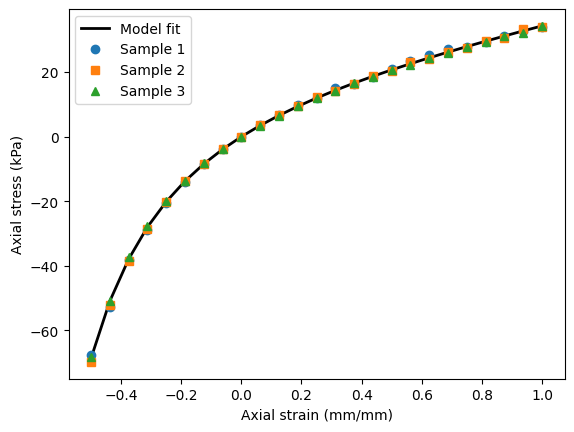

In [11]:
plt.plot(eps_z, S_z_total / 1e3, 'k', lw = 2, label = 'Model fit')
plt.plot(data_1['strain_data'], data_2['stress_data'] / 1e3, 'o', label = 'Sample 1')
plt.plot(data_2['strain_data'], data_1['stress_data'] / 1e3, 's', label = 'Sample 2')
plt.plot(data_3['strain_data'], data_3['stress_data'] / 1e3, '^', label = 'Sample 3')
plt.xlabel('Axial strain (mm/mm)')
plt.ylabel('Axial stress (kPa)')
plt.legend()
plt.show()

### Improving performance of the optimisation solver

The performance of the optimisation solver can be improved by using normalised values of the parameters.  An easy way to do this is to pass an list of values to normalise the parameters with to the `solve` method.

In [12]:
# normalise the Young's modulus by 1e5
normalisation_factor = [1e5]

# solve the optimisation problem
fitted_pars = fit.solve(
    fitting_params = fitting_params, 
    normalisation_factors = normalisation_factor
)

----------------------
Stress-strain fit
Optimal parameters:
E_m = 5.0968e+04


## Fitting hydrogel models under constant hydration

If fitting a hydrogel model to stress-strain data, it may be desirable to vary one or parameters while ensuring the initial degree of hydration remains constant.  This means that as the other parameters vary, the Flory parameter $\chi$ is also automatically updated as well.  This is easily achieved by setting the `fixed_hydration` keyword argument to True when calling the `solve` method.

To see this as an example, let's fit a neo-Hookean hydrogel model to the above data keeping the porosity of the hydrated state fixed at $\phi_0 = 0.7$.

In [13]:
# define the model
mech = uc.mechanics.NeoHookean()
os = uc.osmosis.FloryHuggins()
perm = None

# define the parameters and update the porosity to 0.7 (fixed throughout the fitting)
pars = uc.parameters.example_parameters.Hydrogel()
pars.update('phi_0', 0.7)

# create the model
model = uc.base_models.Hydrogel(mech, perm, os, pars)

Now we create the new data set

In [14]:
# dict with stress and strain data, and model and parameters
data_1 = {
    'strain_data': eps_z,
    'stress_data': S_z_total * (1 + 0.05 * np.random.random(lam_z.shape)),
    'model': model,
    'pars': pars
}

# nested dict with data for all samples
axial_data = {
    'Sample 1': data_1,
}

Now we set up the fitting

In [15]:
# define the dict of fitting parameters and initial guesses
fitting_params = {'E_m': 1e5}

# normalise the Young's modulus by 1e5
normalisation_factor = [1e5]

# define the StressStrain object
fit = uc.fitting.StressStrain(axial_data)

Now we do the fitting, setting the `fixed_hydration` flag to True:

In [16]:
# solve the optimisation problem
fitted_pars = fit.solve(
    fitting_params = fitting_params, 
    normalisation_factors = normalisation_factor,
    fixed_hydration = True
)

----------------------
Stress-strain fit
chi = 0.6282
chi = 0.6282
chi = 0.6297
chi = 0.6297
chi = 0.6288
chi = 0.6288
chi = 0.6294
chi = 0.6294
chi = 0.6289
chi = 0.6289
chi = 0.6288
chi = 0.6288
chi = 0.6295
chi = 0.6295
chi = 0.6289
chi = 0.6289
chi = 0.6288
chi = 0.6288
chi = 0.6288
chi = 0.6288
chi = 0.6288
chi = 0.6288
Optimal parameters:
E_m = 6.0120e+04


Here, we see that the optimal value of the Young's modulus is $62$ kPa and the corresponding value of the Flory parameter is $\chi = 0.6288$.